<center><h1>PCA</h1></center>

# 1. Introduction

Principal Component Analysis (PCA) is a powerful unsupervised machine learning technique used for dimensionality reduction. It transforms high-dimensional data into a lower-dimensional form while preserving as much of the original variance as possible. This is achieved by identifying new axes, called *principal components*, that capture the maximum variability in the data.

PCA is widely used in fields such as data visualization, noise reduction, and feature extraction. By reducing the number of features, PCA helps to simplify models, speed up computations, and potentially improve performance in downstream tasks like classification or clustering.


![PCA](PCA.webp)

# 2. How Does PCA Work?

Principal Component Analysis (PCA) works by identifying the directions (called *principal components*) along which the variance of the data is maximized. These directions are computed from the data's covariance structure and provide a new set of axes that are uncorrelated and ordered by the amount of variance they capture.


1. **Standardize the Data**
   PCA is affected by the scale of the features, so it's important to standardize the dataset before applying PCA. This involves centering each feature by subtracting the mean and scaling to unit variance.

2. **Compute the Covariance Matrix**
   After standardizing, PCA computes the covariance matrix to understand how features vary with respect to each other.

   $$
   \text{Cov}(X) = \frac{1}{n-1} X^T X
   $$

   where $X$ is the standardized data matrix.

3. **Calculate Eigenvectors and Eigenvalues**
   The eigenvectors of the covariance matrix represent the directions of the new feature space (principal components), and the corresponding eigenvalues indicate the amount of variance carried in each direction.

4. **Sort Eigenvectors by Decreasing Eigenvalues**
   The eigenvectors are ranked by their eigenvalues in descending order. The top $k$ eigenvectors form a new feature space that captures the most significant structure of the data.

5. **Project Data onto the New Feature Space**
   The original data is projected onto the space defined by the top $k$ principal components. This results in a lower-dimensional representation that retains most of the important information.

   $$
   X_{\text{reduced}} = X \cdot W_k
   $$

   where $W_k$ is the matrix of the top $k$ eigenvectors.

### Key Characteristics of PCA:

- **Unsupervised**: PCA does not use any label information.
- **Linear**: PCA finds a linear combination of features to project the data.
- **Orthogonal Components**: The principal components are orthogonal (uncorrelated) to each other.
- **Variance Preservation**: The first few principal components capture the majority of the variance in the data.

---

# 3. About the Online Retail Dataset

### Context
Online Retail is a transnational dataset that contains all the transactions occurring between **01/12/2010** and **09/12/2011** for a UK-based and registered non-store online retailer. The company primarily sells unique all-occasion gifts. Many of the company's customers are wholesalers.

### Business Goal
We will be using the Online Retail transnational dataset to build an **RFM (Recency, Frequency, Monetary) clustering** model and select the best set of customers that the company should target.

---

# 4. Steps to Apply PCA to Online Retail Dataset

## 4.1 Data Loading and Initial Exploration
- Load the dataset into a DataFrame
- Display basic information and check for missing values
- Understand key features like InvoiceNo, StockCode, Quantity, InvoiceDate, UnitPrice, CustomerID


In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv('OnlineRetail.csv',encoding='ISO-8859-1')  # Replace with the correct file path if needed

# Display the first few rows
print("First few rows:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())

# Check unique value counts for key categorical columns
print("\nUnique InvoiceNo:", df['InvoiceNo'].nunique())
print("Unique StockCode:", df['StockCode'].nunique())
print("Unique Customers:", df['CustomerID'].nunique())

First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------      

## 4.2 Data Cleaning and Preprocessing
- Remove missing CustomerID entries
- Filter out canceled transactions (InvoiceNo starting with 'C')
- Remove negative or zero quantity and price values
- Create a meaningful feature set for PCA


In [7]:
# Remove rows where 'CustomerID' is missing
df_clean = df.dropna(subset=['CustomerID'])

# Filter out canceled transactions (those with 'InvoiceNo' starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].str.startswith('C')]

# Remove rows with negative or zero 'Quantity' and 'UnitPrice'
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Create a meaningful feature set for PCA: we will use 'Quantity' and 'UnitPrice'
# Calculate the total value for each transaction (Quantity * UnitPrice)
df_clean['TotalValue'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Aggregate data at the customer level (using 'CustomerID')
df_customer = df_clean.groupby('CustomerID').agg(
    total_quantity=('Quantity', 'sum'),
    total_value=('TotalValue', 'sum'),
    average_unit_price=('UnitPrice', 'mean'),
    frequency=('InvoiceNo', 'nunique')
).reset_index()

# Display the first few rows of the cleaned and aggregated data
df_customer.head()

,CustomerID,total_quantity,total_value,average_unit_price,frequency
0,12346.0,74215,77183.60,1.040000,1
1,12347.0,2458,4310.00,2.644011,7
2,12348.0,2341,1797.24,5.764839,4
3,12349.0,631,1757.55,8.289041,1
4,12350.0,197,334.40,3.841176,1


## 4.3 Feature Engineering
- Aggregate data at the customer level (e.g., total quantity, average unit price, etc.)
- Normalize or standardize the features to prepare for PCA


In [8]:
# Aggregating data at the customer level
df_customer = df_clean.groupby('CustomerID').agg(
    total_quantity=('Quantity', 'sum'),
    total_value=('TotalValue', 'sum'),
    average_unit_price=('UnitPrice', 'mean'),
    frequency=('InvoiceNo', 'nunique')
).reset_index()

# Display the first few rows of the aggregated customer data
df_customer.head()

# Standardizing the features to prepare for PCA
from sklearn.preprocessing import StandardScaler

# Selecting numerical features for PCA
features = df_customer[['total_quantity', 'total_value', 'average_unit_price', 'frequency']]

# Standardizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert the scaled features back into a DataFrame
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)

# Display the first few rows of the scaled data
df_scaled.head()

,total_quantity,total_value,average_unit_price,frequency
0,14.473038,8.358668,-0.100205,-0.425097
1,0.251058,0.250966,-0.053315,0.354417
2,0.227869,-0.028596,0.037918,-0.035340
3,-0.111047,-0.033012,0.111708,-0.425097
4,-0.197065,-0.191347,-0.018318,-0.425097


## 4.4 Applying PCA
- Use `StandardScaler` to scale the data
- Apply PCA using `sklearn.decomposition.PCA`
- Determine the number of components using explained variance ratio


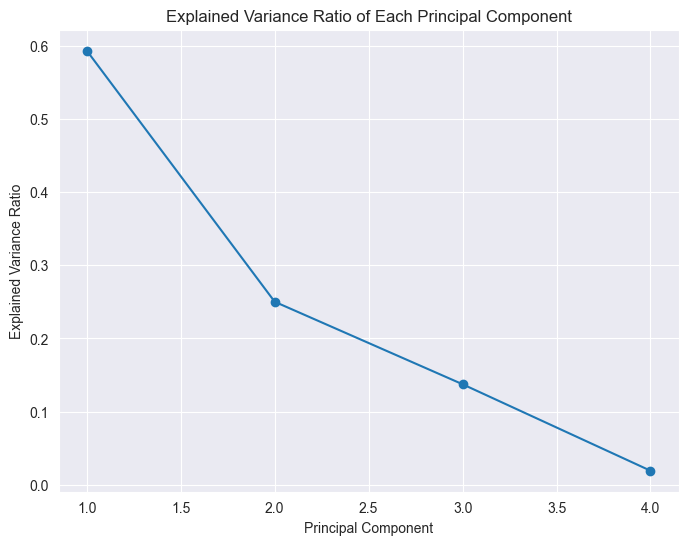

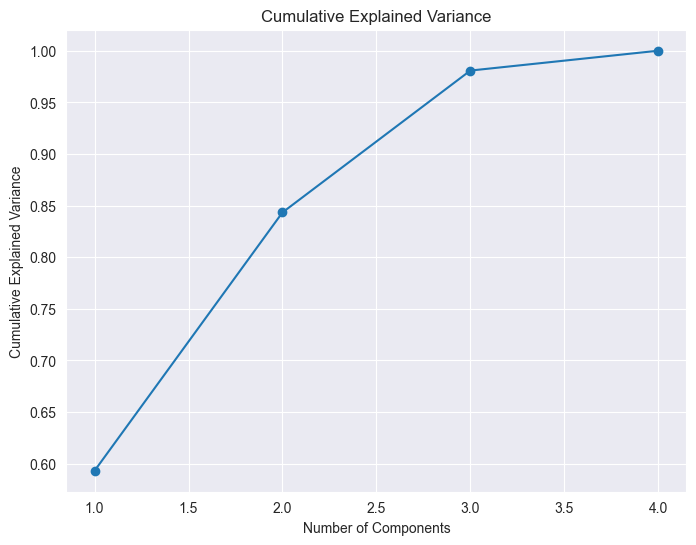

Number of components explaining 95% variance: 3


In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to the scaled data
pca = PCA()
pca.fit(df_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio for each principal component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Calculate the cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Determine the number of components to retain (e.g., 95% explained variance)
num_components = (cumulative_explained_variance <= 0.95).sum() + 1  # Get the number of components that explain >= 95%
print(f"Number of components explaining 95% variance: {num_components}")

## 4.5 Visualizing PCA Results
- Plot the explained variance
- Scatter plot of the first two principal components
- Analyze clustering tendencies in reduced space


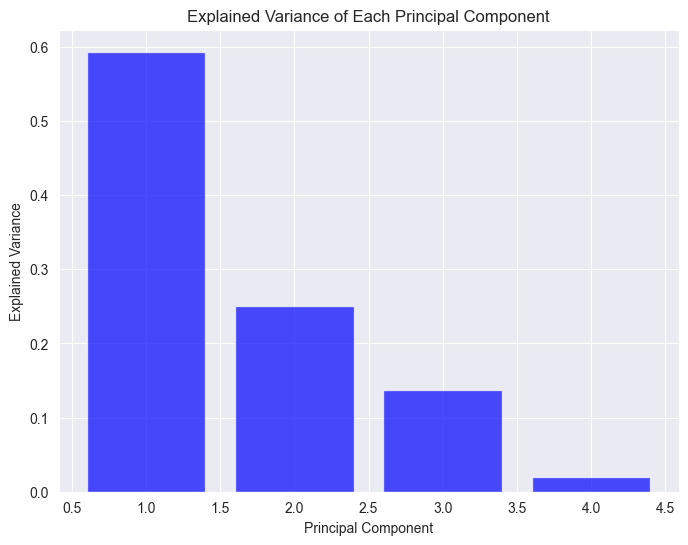

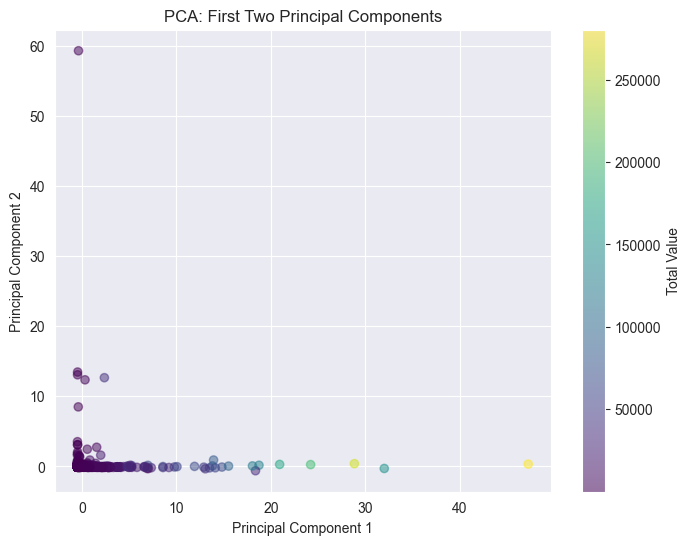

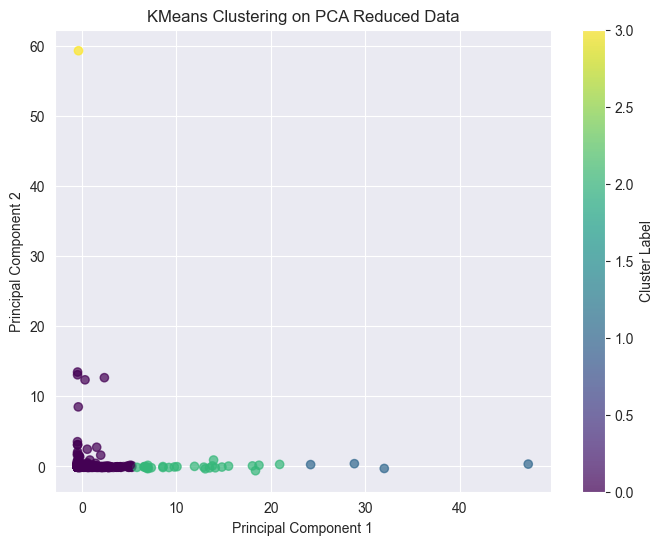

In [10]:
# Plot the explained variance for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='b')
plt.title('Explained Variance of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

# Scatter plot of the first two principal components
# Project the data onto the first two principal components
pca_2d = pca.transform(df_scaled)[:, :2]

plt.figure(figsize=(8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], alpha=0.5, c=df_customer['total_value'], cmap='viridis')
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Total Value')
plt.show()

# Optional: Analyzing clustering tendencies in reduced space
# Here we can use a clustering algorithm like KMeans on the first two components (optional step)
from sklearn.cluster import KMeans

# Perform KMeans clustering on the reduced data
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_2d)

# Plot the KMeans clustering results
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering on PCA Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

## 4.6 Interpretation and Next Steps
- Discuss findings from the PCA results

### PCA Results

The PCA results indicate that the **first principal component** explains the majority of the variance (around **0.6**), suggesting it captures the most significant patterns in the data. The **second principal component** accounts for a moderate amount of variance (around **0.25**), while subsequent components contribute progressively less, with the **fourth and beyond** showing negligible variance. This suggests that the first two components likely represent the most important features or dimensions of the dataset.

### Scatter Plot

The scatter plot of the first two principal components shows a **clear separation of data points**, with some clustering observable, particularly along the first component.
